Utilize geospatial visualization techniques to generate a choropleth map showcasing the divergence in prices for 4-Room HDB resale flats across distinct regions of Singapore, potentially leveraging the boundaries outlined in the Singapore Master Plan 2014. Then analyze the map to discern any potential correlations between HDB resale prices and their proximity to the CBD.

# Step 1: Create SVY21 Converter 

SVY21 is a geodetic datum which is introduced in Singapore whereas WSG84 is standard for GPS. Gooplemap only provides WSG84. 

Below is the Python Class for conversion between SVY21 and WSG84 

In [1]:
#Convert between Lat/Lon, and SVY21
#from https://github.com/cgcai/SVY21

import math
from sys import argv
import csv

class SVY21:
    # Ref: http://www.linz.govt.nz/geodetic/conversion-coordinates/projection-conversions/transverse-mercator-preliminary-computations/index.aspx

    # WGS84 Datum
    a = 6378137
    f = 1 / 298.257223563

    # SVY21 Projection
    # Fundamental point: Base 7 at Pierce Resevoir.
    # Latitude: 1 22 02.9154 N, longitude: 103 49 31.9752 E (of Greenwich).

    # Known Issue: Setting (oLat, oLon) to the exact coordinates specified above
    # results in computation being slightly off. The values below give the most
    # accurate represenation of test data.
    oLat = 1.366666  # origin's lat in degrees
    oLon = 103.833333  # origin's lon in degrees
    oN = 38744.572  # false Northing
    oE = 28001.642  # false Easting
    k = 1  # scale factor

    #
    def __init__(self):
        self.b = self.a * (1 - self.f)
        self.e2 = (2 * self.f) - (self.f * self.f)
        self.e4 = self.e2 * self.e2
        self.e6 = self.e4 * self.e2
        self.A0 = 1 - (self.e2 / 4) - (3 * self.e4 / 64) - (5 * self.e6 / 256);
        self.A2 = (3. / 8.) * (self.e2 + (self.e4 / 4) + (15 * self.e6 / 128));
        self.A4 = (15. / 256.) * (self.e4 + (3 * self.e6 / 4));
        self.A6 = 35 * self.e6 / 3072;

    def computeSVY21(self, lat, lon):
        """
        Returns a pair (N, E) representing Northings and Eastings in SVY21.
        """

        latR = lat * math.pi / 180
        sinLat = math.sin(latR)
        sin2Lat = sinLat * sinLat
        cosLat = math.cos(latR)
        cos2Lat = cosLat * cosLat
        cos3Lat = cos2Lat * cosLat
        cos4Lat = cos3Lat * cosLat
        cos5Lat = cos4Lat * cosLat
        cos6Lat = cos5Lat * cosLat
        cos7Lat = cos6Lat * cosLat

        rho = self.calcRho(sin2Lat)
        v = self.calcV(sin2Lat)
        psi = v / rho
        t = math.tan(latR)
        w = (lon - self.oLon) * math.pi / 180

        M = self.calcM(lat)
        Mo = self.calcM(self.oLat)

        w2 = w * w
        w4 = w2 * w2
        w6 = w4 * w2
        w8 = w6 * w2

        psi2 = psi * psi
        psi3 = psi2 * psi
        psi4 = psi3 * psi

        t2 = t * t
        t4 = t2 * t2
        t6 = t4 * t2

        # Compute Northing
        nTerm1 = w2 / 2 * v * sinLat * cosLat
        nTerm2 = w4 / 24 * v * sinLat * cos3Lat * (4 * psi2 + psi - t2)
        nTerm3 = w6 / 720 * v * sinLat * cos5Lat * (
                (8 * psi4) * (11 - 24 * t2) - (28 * psi3) * (1 - 6 * t2) + psi2 * (1 - 32 * t2) - psi * 2 * t2 + t4)
        nTerm4 = w8 / 40320 * v * sinLat * cos7Lat * (1385 - 3111 * t2 + 543 * t4 - t6)
        N = self.oN + self.k * (M - Mo + nTerm1 + nTerm2 + nTerm3 + nTerm4)

        # Compute Easting
        eTerm1 = w2 / 6 * cos2Lat * (psi - t2)
        eTerm2 = w4 / 120 * cos4Lat * ((4 * psi3) * (1 - 6 * t2) + psi2 * (1 + 8 * t2) - psi * 2 * t2 + t4)
        eTerm3 = w6 / 5040 * cos6Lat * (61 - 479 * t2 + 179 * t4 - t6)
        E = self.oE + self.k * v * w * cosLat * (1 + eTerm1 + eTerm2 + eTerm3)

        return (N, E)

    def calcM(self, lat):
        latR = lat * math.pi / 180
        return self.a * ((self.A0 * latR) - (self.A2 * math.sin(2 * latR)) + (self.A4 * math.sin(4 * latR)) - (
                self.A6 * math.sin(6 * latR)))

    def calcRho(self, sin2Lat):
        num = self.a * (1 - self.e2)
        denom = math.pow(1 - self.e2 * sin2Lat, 3. / 2.)
        return num / denom

    def calcV(self, sin2Lat):
        poly = 1 - self.e2 * sin2Lat
        return self.a / math.sqrt(poly)

    def computeLatLon(self, N, E):
        """
        Returns a pair (lat, lon) representing Latitude and Longitude.
        """

        Nprime = N - self.oN
        Mo = self.calcM(self.oLat)
        Mprime = Mo + (Nprime / self.k)
        n = (self.a - self.b) / (self.a + self.b)
        n2 = n * n
        n3 = n2 * n
        n4 = n2 * n2
        G = self.a * (1 - n) * (1 - n2) * (1 + (9 * n2 / 4) + (225 * n4 / 64)) * (math.pi / 180)
        sigma = (Mprime * math.pi) / (180. * G)

        latPrimeT1 = ((3 * n / 2) - (27 * n3 / 32)) * math.sin(2 * sigma)
        latPrimeT2 = ((21 * n2 / 16) - (55 * n4 / 32)) * math.sin(4 * sigma)
        latPrimeT3 = (151 * n3 / 96) * math.sin(6 * sigma)
        latPrimeT4 = (1097 * n4 / 512) * math.sin(8 * sigma)
        latPrime = sigma + latPrimeT1 + latPrimeT2 + latPrimeT3 + latPrimeT4

        sinLatPrime = math.sin(latPrime)
        sin2LatPrime = sinLatPrime * sinLatPrime

        rhoPrime = self.calcRho(sin2LatPrime)
        vPrime = self.calcV(sin2LatPrime)
        psiPrime = vPrime / rhoPrime
        psiPrime2 = psiPrime * psiPrime
        psiPrime3 = psiPrime2 * psiPrime
        psiPrime4 = psiPrime3 * psiPrime
        tPrime = math.tan(latPrime)
        tPrime2 = tPrime * tPrime
        tPrime4 = tPrime2 * tPrime2
        tPrime6 = tPrime4 * tPrime2
        Eprime = E - self.oE
        x = Eprime / (self.k * vPrime)
        x2 = x * x
        x3 = x2 * x
        x5 = x3 * x2
        x7 = x5 * x2

        # Compute Latitude
        latFactor = tPrime / (self.k * rhoPrime)
        latTerm1 = latFactor * ((Eprime * x) / 2)
        latTerm2 = latFactor * ((Eprime * x3) / 24) * (
                (-4 * psiPrime2) + (9 * psiPrime) * (1 - tPrime2) + (12 * tPrime2))
        latTerm3 = latFactor * ((Eprime * x5) / 720) * (
                (8 * psiPrime4) * (11 - 24 * tPrime2) - (12 * psiPrime3) * (21 - 71 * tPrime2) + (
                15 * psiPrime2) * (15 - 98 * tPrime2 + 15 * tPrime4) + (180 * psiPrime) * (
                        5 * tPrime2 - 3 * tPrime4) + 360 * tPrime4)
        latTerm4 = latFactor * ((Eprime * x7) / 40320) * (1385 - 3633 * tPrime2 + 4095 * tPrime4 + 1575 * tPrime6)
        lat = latPrime - latTerm1 + latTerm2 - latTerm3 + latTerm4

        # Compute Longitude
        secLatPrime = 1. / math.cos(lat)
        lonTerm1 = x * secLatPrime
        lonTerm2 = ((x3 * secLatPrime) / 6) * (psiPrime + 2 * tPrime2)
        lonTerm3 = ((x5 * secLatPrime) / 120) * ((-4 * psiPrime3) * (1 - 6 * tPrime2) + psiPrime2 * (
                9 - 68 * tPrime2) + 72 * psiPrime * tPrime2 + 24 * tPrime4)
        lonTerm4 = ((x7 * secLatPrime) / 5040) * (61 + 662 * tPrime2 + 1320 * tPrime4 + 720 * tPrime6)
        lon = (self.oLon * math.pi / 180) + lonTerm1 - lonTerm2 + lonTerm3 - lonTerm4

        return (lat / (math.pi / 180), lon / (math.pi / 180))


def csvConverter():
    
    cv = SVY21()
    with open(argv[2], "a") as output:
        write = csv.writer(output)
        
        #Y IS LAT AND X IS LON
        write.writerow(["Y", "X"])
    output.close()

    with open(argv[1], 'r') as csvfile:
        input = csv.reader(csvfile)
        next(input)
        for row in input:
            # print(row[0], row[1])
            x = float(row[1])
            y = float(row[0])
            result = cv.computeLatLon(y, x)

            with open(argv[2], "a") as output:
                write = csv.writer(output)
                write.writerow(result)

            output.close()

        print("Done! Check output.csv file in folder")

    csvfile.close()
    

# Step 2: Dataset 1: Extracting and Processing

In [2]:
import pandas as pd

price = pd.read_csv('data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [3]:
# Filter for 4 Room to reduce the data size
df = price.loc[price['flat_type'] == "4 ROOM"]

# New Columns with concatenated address
# Adding 'Block' is critical because some will not found in the cell
df['addresses'] = "Block " + price.block + " " + price.street_name + " " + "Singapore"

<ipython-input-3-1ce33b6e81e5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['addresses'] = "Block " + price.block + " " + price.street_name + " " + "Singapore"


In [4]:
#Reset the Index Number after the above filter
df = df.reset_index(drop=True)

#Statistic Summary
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,34288.000000,34288.000000,3.428800e+04
mean,95.385622,1997.686158,4.350983e+05
std,7.236761,12.228888,1.199370e+05
min,70.000000,1967.000000,2.180000e+05
25%,91.000000,1987.000000,3.550000e+05
50%,93.000000,1998.000000,4.050000e+05
75%,102.000000,2011.000000,4.700000e+05
max,138.000000,2019.000000,1.186888e+06


The max and min resale price of 4-room have high difference of about a million. It might be due to lease date and floor area. 

Newer unit is seen to be more expensive than older unit since all HDB is having 99-year of lease period. A new feature called leftover yeas will be created. 

Bigger area will also One way to improve the dataset is to create a new feature - price per sqm. 

<AxesSubplot:>

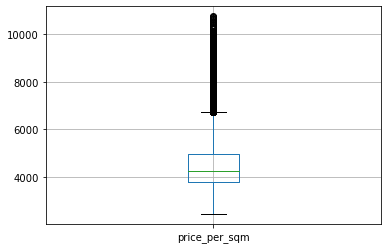

In [5]:
# 2 New Features

df['leftover_year'] = 99- (2020 - price.lease_commence_date.astype(int))

df['price_per_sqm'] = round(price.resale_price/price.floor_area_sqm,0)

df.describe()

df.boxplot(column=['price_per_sqm'] )

The outliers are found outside of the upper whisker which led to skew more to right in density plot that found below.  

<AxesSubplot:ylabel='Density'>

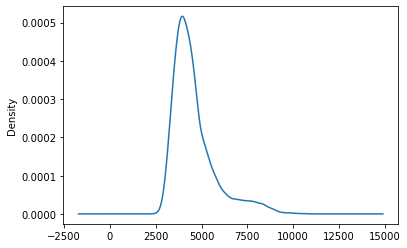

In [6]:
df.price_per_sqm.plot.density()

To increase significant association, it will be a good move to remove the outlier. The next step of data processing is to decide on significance level. Typically is either 95% or 90%.  

count    32571.000000
mean      4378.189985
std        875.465425
min       2439.000000
25%       3750.000000
50%       4214.000000
75%       4797.000000
max       7304.000000
Name: price_per_sqm, dtype: float64
median 4214.0


<AxesSubplot:>

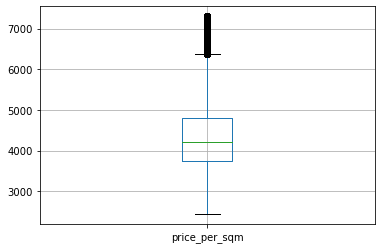

In [7]:
# significance level of 95% 

q5 = 5 

q5_hi = df["price_per_sqm"].quantile(1 - (q5/100))

q5 = df[(df["price_per_sqm"] < q5_hi)]
print(q5["price_per_sqm"].describe())
print('median ' + str(q5["price_per_sqm"].median()))

q5.boxplot(column=['price_per_sqm'] )


Outliers are still observed outside of the upper whisker. 

count    30858.000000
mean      4251.169940
std        704.009148
min       2439.000000
25%       3727.000000
50%       4164.000000
75%       4679.750000
max       6134.000000
Name: price_per_sqm, dtype: float64
median 4164.0


<AxesSubplot:>

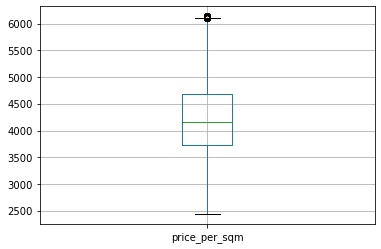

In [8]:
# significance level of 90% 

q10 = 10 
q10_hi = df["price_per_sqm"].quantile(1 - (q10/100))

q10 = df[(df["price_per_sqm"] < q10_hi)]
print(q10["price_per_sqm"].describe())
print('median ' + str(q10["price_per_sqm"].median()))

q10.boxplot(column=['price_per_sqm'] )

At 90% significance level, it has removed most of the ouliers in dataset 1. The values for mean and medium are nearer to each other.  

In [9]:
# Renumber the index again

df = q10.reset_index(drop=True)

Extract each address from Googlemaps to save in the format of json. 
This is to extract 2 more feature latitude and longitude from json into the dataframe - dataset 1. 

Total number of json files: 30858

In [10]:
index_count = 30858

In [11]:
#cautious: Takes 10min to run
import json
from shapely.geometry import Point, Polygon

for count in range(0,index_count):     
    
    # Extract from json file
    with open('data/addresses/index_' + str(count) + '.txt') as f:
        json_file = json.load(f)
        lng = json_file['geometry']['location']['lng']
        lat = json_file['geometry']['location']['lat']
        formatted_address =json_file['formatted_address']
        
        # convert from WSG84 to SVY21
        cv = SVY21()
        (N, E) = cv.computeSVY21(lat, lng)
        # Create Point objects
        geometry = Point(E, N)
        
        #Updated to dataframe: Dataset 1
        df.at[count,'lng'] = lng
        df.at[count,'lat'] = lat
        df.at[count,'addresses'] = formatted_address
        df.at[count,'geometry'] = str(geometry)

To change Dataset 1  from df to gdf where gdf is the format of GeoDataframe. 

In [12]:
from shapely import wkt
import geopandas as gpd


for i in range(0,1):
    try: 
        df.geometry= df.geometry.apply(wkt.loads)  
    except:
        break

gdf = gpd.GeoDataFrame(df, geometry='geometry')

To check if geometry has successfully converted  for data type from object to geometry.

In [13]:
gdf.dtypes

month                    object
town                     object
flat_type                object
block                    object
street_name              object
storey_range             object
floor_area_sqm          float64
flat_model               object
lease_commence_date       int64
remaining_lease          object
resale_price            float64
addresses                object
leftover_year             int32
price_per_sqm           float64
lng                     float64
lat                     float64
geometry               geometry
dtype: object

In [14]:
gdf.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,addresses,leftover_year,price_per_sqm,lng,lat,geometry
0,2017-01,ANG MO KIO,4 ROOM,472,ANG MO KIO AVE 10,10 TO 12,92.0,New Generation,1979,61 years 06 months,400000.0,"472 Ang Mo Kio Ave 10, Block 472, Singapore 56...",58,5273.0,103.858085,1.363180,POINT (30756.192 38359.100)
1,2017-01,ANG MO KIO,4 ROOM,475,ANG MO KIO AVE 10,07 TO 09,91.0,New Generation,1979,61 years 06 months,400000.0,"475 Ang Mo Kio Ave 10, Block 475, Singapore 56...",57,3731.0,103.856612,1.362694,POINT (30592.365 38305.381)
2,2017-01,ANG MO KIO,4 ROOM,629,ANG MO KIO AVE 4,01 TO 03,94.0,New Generation,1981,63 years 09 months,403000.0,"629 Ang Mo Kio Ave 4, Singapore 560629",59,3910.0,103.840420,1.380135,POINT (28790.358 40233.918)
3,2017-01,ANG MO KIO,4 ROOM,546,ANG MO KIO AVE 10,01 TO 03,92.0,New Generation,1981,63 years,410000.0,"546 Ang Mo Kio Ave 10, Singapore 560546",59,3897.0,103.856788,1.373480,POINT (30611.896 39498.042)
4,2017-01,ANG MO KIO,4 ROOM,131,ANG MO KIO AVE 3,01 TO 03,98.0,New Generation,1979,61 years 01 month,425888.0,"131 Ang Mo Kio Ave 3, Block 131, Singapore 560131",59,3955.0,103.841779,1.371041,POINT (28941.568 39228.328)


# Step 3: Dataset 2: Extracting and Plotting

Second Dataset will be shapefile format and extracted from 
https://data.gov.sg/dataset/master-plan-2014-planning-area-boundary-no-sea

The dataset will be represented as b_map (boundary map).

In [15]:
import geopandas as gpd

shapefile = "data/MP14_PLNG_AREA_NO_SEA_PL.shp"
b_map = gpd.read_file(shapefile)

In [16]:
b_map

,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,geometry
0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,40229.1238,17494.240190,1.394138e+07,"POLYGON ((30658.500 42047.527, 30679.195 42020..."
1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,34032.0961,21872.798962,2.173319e+07,"POLYGON ((38974.269 36138.243, 39371.471 35747..."
2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,37450.8865,13517.121556,7.618921e+06,"POLYGON ((29772.191 38311.805, 29784.826 38304..."
3,4,BOON LAY,BL,N,WEST REGION,WR,A3DC87118B43CDED,2016-05-11,13410.3824,33008.9884,18528.467448,8.279408e+06,"POLYGON ((12861.383 32207.492, 12860.555 32208..."
4,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,37527.6527,15234.223423,1.113326e+07,"POLYGON ((20294.455 39114.528, 20334.318 39054..."
5,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,28662.8732,29156.293788,1.446247e+07,"POLYGON ((26228.631 30746.197, 26231.960 30743..."
6,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,38761.8448,15891.853279,9.019940e+06,"POLYGON ((21448.724 41356.741, 21508.535 40890..."
7,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,34689.0037,22492.840844,1.752665e+07,"POLYGON ((24031.387 36694.742, 24076.658 36657..."
8,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,33683.8190,12959.116844,9.643156e+06,"POLYGON ((35619.754 32450.586, 35588.223 32427..."
9,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,32515.7735,15584.137724,9.169902e+06,"POLYGON ((31277.373 34723.293, 31305.947 34712..."


Text(0.5, 1.0, 'Singapore Map')

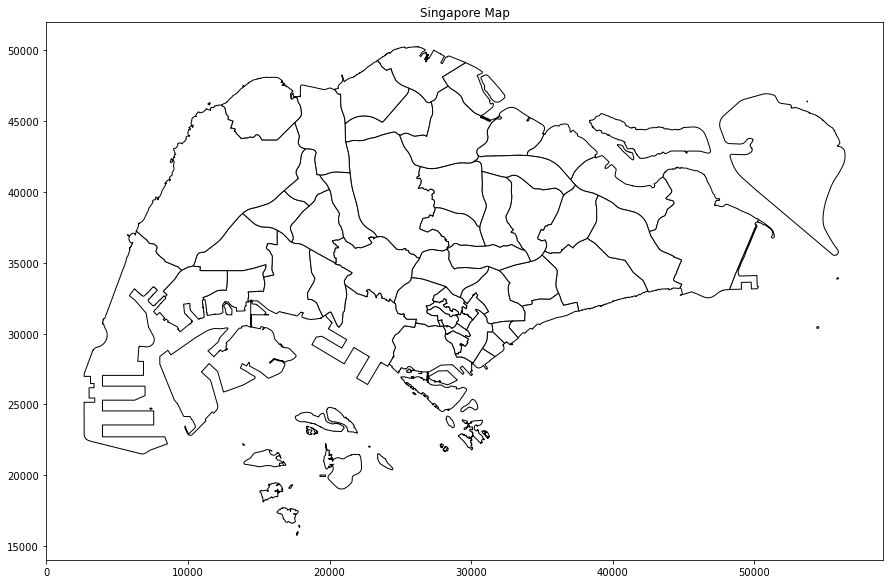

In [17]:
#plot Singapore map

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,15))
b_map.plot(ax = ax, color = 'white', edgecolor = 'black').set_title('Singapore Map')

# Step 4: Merging of Dataset 1 and 2  

The following are the objectives:  

1. Dataset 1 (gdf.['town']) should match with Dataset 2 (b_map[PLN_AREA_N]). 

2. New features in Dataset 2 (b_map) for price at (a) percentile for 25%, 50%, 75% and (b) mean (c) Standard Deviation. 

Objective 1: Dataset Matching

In [18]:
#UniqueTown for dataset 1 (gdf)
x = gdf.town.unique()

#Unique Town for dataset 2 (b_map)
y = b_map.PLN_AREA_N.unique()

In [19]:
# Outer Join for dataset 1
print([z for z in x if z not in y])

['CENTRAL AREA', 'KALLANG/WHAMPOA']


In [20]:
#Update 'KALLANG/WHAMPOA' to 'KALLANG'
gdf.loc[gdf.town == 'KALLANG/WHAMPOA','town'] = 'KALLANG'

In [21]:
#Change the CENTRAL AREA (Dataset 1) to other district names that found in Dataset 2

CBD_index = list(gdf.loc[gdf.town == 'CENTRAL AREA','town'].index)
for i in CBD_index:    
    for j in range(0,len(b_map)):
        check = gdf.geometry[i].within(b_map.geometry[j])
        if check == True: 
            gdf.at[i,'town'] = b_map.PLN_AREA_N[j]


Dataset 1

1. gdf.geometry is the coordinate point of the address
2. gdf.town is the district name

Dataset 2

1. b_map.geometry is the area of the district
2. b_map.PLN_AREA_N is the district name


In [22]:
#Check for the point (address)  is fall within the polygon (district) 
# Also check for matching of district names from dataset 1 and 2.

from shapely.geometry import Point, Polygon

for i in range(0,len(gdf)):
    for j in range(0,len(b_map)):
        
        check1 = gdf.geometry[i].within(b_map.geometry[j])
        check2 = str(gdf.town[i]) == str(b_map.PLN_AREA_N[j])
        
        # When Check 1 and Check 2 are true, it will report as acceptable
        if check1 == True and check2 == True:
            gdf.at[i,'check'] = 'Acceptable'
            break
        # When Check 1 is true and Check 2 is false, it will correct the gdf.town to b_map.PLN_AREA_N. 
        #Then report as acceptable. 
        elif check1 == True and check2 == False:
            gdf.at[i,'town'] = b_map.PLN_AREA_N[j]
            gdf.at[i,'check'] = 'Acceptable'
            break 
        if j == (len(b_map)-1):
            gdf.at[i,'check'] = 'Discrepency'

gdf.loc[gdf.check == 'Acceptable'].shape

(30858, 18)

All are acceptable and there is no discrepency. Let's proceed to next objective. 

Objective 2: New Features in Dataset 2

In [23]:
#UniqueTown for dataset 1 (gdf)
districts = list(b_map.PLN_AREA_N)
count = -1
for district in districts:
    count += 1 
    try:
        # Summaries the statistical results in dataset 1
        x = list(gdf.loc[gdf.town == district,'price_per_sqm'].describe())
        
        # This is to ensure there are sufficient number of counts in each district; otherwise it will be meaningless
        if x[0] > 50:
            district_count = x[0]
            district_mean = x[1]
            district_std = x[2]
            district_min = x[3]
            district_25 = x[4]
            district_50 = x[5]
            district_75 = x[6]
            district_max = x[7]
        
            # Update the statistical results into new Features in dataset 2
            b_map.at[count,'district_count'] = district_count
            b_map.at[count,'district_mean'] = district_mean
            b_map.at[count,'district_std'] = district_std
            b_map.at[count,'district_min'] = district_min
            b_map.at[count,'district_25'] = district_25
            b_map.at[count,'district_50'] = district_50
            b_map.at[count,'district_75'] = district_75
            b_map.at[count,'district_max'] = district_max
        
        # Less than 50 counts will be skipped (Tanglin amd Downtown Core are skipped due to having 3 and 13 respectively)
        else:
            continue
    
    except:
        continue

In [24]:
b_map

,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,...,SHAPE_Area,geometry,district_count,district_mean,district_std,district_min,district_25,district_50,district_75,district_max
0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,40229.1238,...,1.394138e+07,"POLYGON ((30658.500 42047.527, 30679.195 42020...",925.0,4207.618378,708.798227,2582.0,3689.00,4098.0,4699.00,6125.0
1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,34032.0961,...,2.173319e+07,"POLYGON ((38974.269 36138.243, 39371.471 35747...",1338.0,4284.937220,706.454949,2598.0,3777.00,4169.0,4706.00,6131.0
2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,37450.8865,...,7.618921e+06,"POLYGON ((29772.191 38311.805, 29784.826 38304...",727.0,4202.955983,675.496979,2837.0,3714.00,4118.0,4624.50,6113.0
3,4,BOON LAY,BL,N,WEST REGION,WR,A3DC87118B43CDED,2016-05-11,13410.3824,33008.9884,...,8.279408e+06,"POLYGON ((12861.383 32207.492, 12860.555 32208...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,37527.6527,...,1.113326e+07,"POLYGON ((20294.455 39114.528, 20334.318 39054...",1083.0,4387.691597,670.327979,2689.0,3909.00,4348.0,4790.00,6123.0
5,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,28662.8732,...,1.446247e+07,"POLYGON ((26228.631 30746.197, 26231.960 30743...",1052.0,4261.888783,709.783383,2689.0,3701.00,4188.5,4776.00,6134.0
6,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,38761.8448,...,9.019940e+06,"POLYGON ((21448.724 41356.741, 21508.535 40890...",1353.0,4254.913525,739.543011,2449.0,3691.00,4118.0,4710.00,6120.0
7,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,34689.0037,...,1.752665e+07,"POLYGON ((24031.387 36694.742, 24076.658 36657...",76.0,4165.697368,691.315365,3049.0,3714.75,4106.0,4414.75,5841.0
8,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,33683.8190,...,9.643156e+06,"POLYGON ((35619.754 32450.586, 35588.223 32427...",601.0,4197.660566,706.868480,2635.0,3676.00,4146.0,4674.00,6119.0
9,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,32515.7735,...,9.169902e+06,"POLYGON ((31277.373 34723.293, 31305.947 34712...",514.0,4285.980545,668.172081,2837.0,3771.75,4218.0,4663.75,6125.0


# Step 5: Map Plotting

['BOON LAY', 'LIM CHU KANG', 'MANDAI', 'NORTH-EASTERN ISLANDS', 'PIONEER', 'PAYA LEBAR', 'SELETAR', 'CENTRAL WATER CATCHMENT', 'CHANGI', 'SUNGEI KADUT', 'TENGAH', 'MARINA EAST', 'MARINA SOUTH', 'MUSEUM', 'NEWTON', 'CHANGI BAY', 'SINGAPORE RIVER', 'STRAITS VIEW', 'SIMPANG', 'SOUTHERN ISLANDS', 'TUAS', 'WESTERN ISLANDS', 'WESTERN WATER CATCHMENT', 'ORCHARD', 'RIVER VALLEY', 'TANGLIN', 'DOWNTOWN CORE']


Text(0.5, 1.0, 'Housing Map')

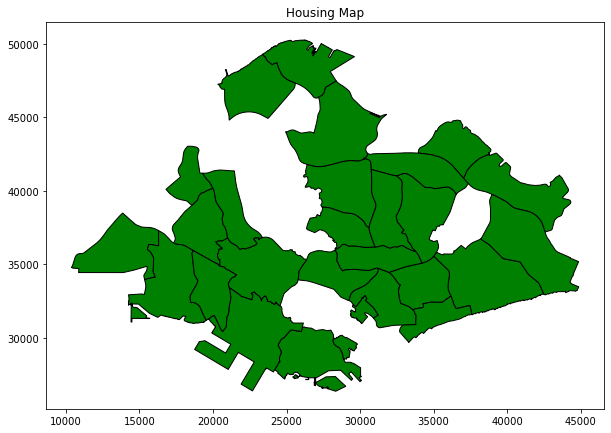

In [30]:
import matplotlib.pyplot as plt

#UniqueTown for dataset 1 (gdf)
x = gdf.town.unique()

#Unique Town for dataset 2 (b_map)
y = b_map.PLN_AREA_N.unique()

# Outer Join for dataset 2
non_housing_districts = [z for z in y if z not in x] + ['TANGLIN', 'DOWNTOWN CORE']
print(non_housing_districts )

# 
housing_map = b_map.query('PLN_AREA_N not in @non_housing_districts')
housing_map = housing_map.reset_index(drop = True)

#plot CBD 
fig, ax = plt.subplots(figsize = (10,10))
housing_map.plot(ax = ax, color = 'green', edgecolor = 'black').set_title('Housing Map')


0    POLYGON ((28536.292 31475.292, 28536.244 31474...
dtype: geometry

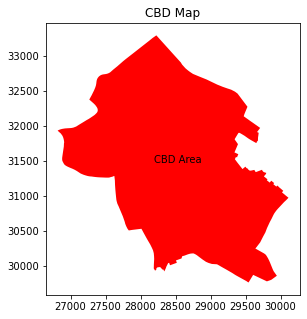

In [55]:
# The followings are the districted that have considered as CBD
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
import re

CBD_Districts = ['MUSEUM','NEWTON','SINGAPORE RIVER','ORCHARD','RIVER VALLEY']
boundary = b_map.query('PLN_AREA_N in @CBD_Districts')

# Union polygons together 
polygons = [poly for poly in boundary.geometry]
CBD_map = gpd.GeoSeries(cascaded_union(polygons))



# Convert data type from geometery to float to include annotate in the plot  
def geotofloat(a):
    z= a.centroid.astype(str)
    x = re.split(" ",z[0])[1][1:]
    y = re.split(" ",z[0])[2][:-1]
    return [float(x),float(y)]

#plot CBD
fig, ax = plt.subplots(figsize = (5,5))
CBD_map.plot(ax = ax, color = 'red').set_title('CBD Map')
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

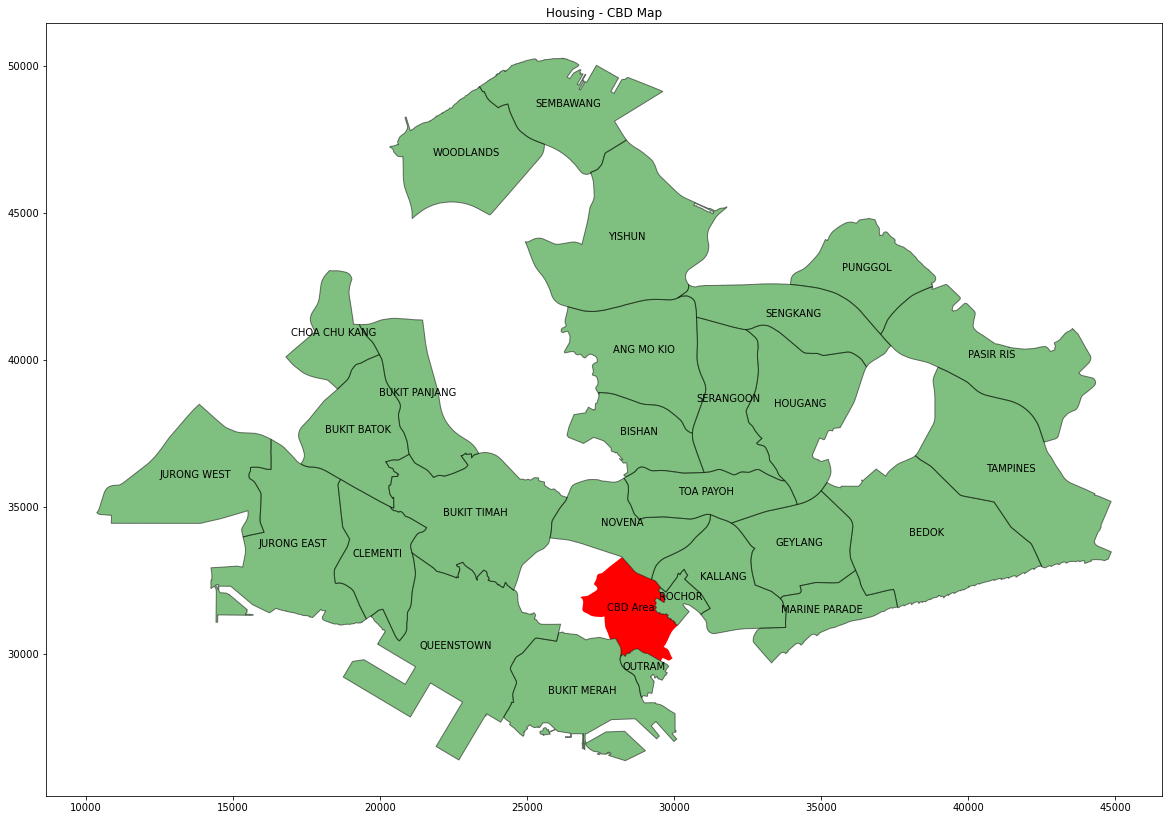

In [96]:
ax = CBD_map.plot(color='red',figsize = (20,20))
housing_map.plot(ax=ax, color='green', edgecolor='black', alpha=0.5).set_title('Housing - CBD Map')

# Include annodate for each district
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)), 
                 horizontalalignment = 'center')

The objective is to plot 4 room resale housing prices into chropleth map in following conditions: 
1. 25 percentile of price_per_sqm on each region
2. 50 percentile of price_per_sqm on each region
3. 75 percentile of price_per_sqm on each region
4. 25, 50, 75 percentile price_per_sqm vs Distance from CBD area 

In [33]:
housing_map

,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,...,SHAPE_Area,geometry,district_count,district_mean,district_std,district_min,district_25,district_50,district_75,district_max
0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,40229.1238,...,1.394138e+07,"POLYGON ((30658.500 42047.527, 30679.195 42020...",925.0,4207.618378,708.798227,2582.0,3689.00,4098.0,4699.00,6125.0
1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,34032.0961,...,2.173319e+07,"POLYGON ((38974.269 36138.243, 39371.471 35747...",1338.0,4284.937220,706.454949,2598.0,3777.00,4169.0,4706.00,6131.0
2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,37450.8865,...,7.618921e+06,"POLYGON ((29772.191 38311.805, 29784.826 38304...",727.0,4202.955983,675.496979,2837.0,3714.00,4118.0,4624.50,6113.0
3,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,37527.6527,...,1.113326e+07,"POLYGON ((20294.455 39114.528, 20334.318 39054...",1083.0,4387.691597,670.327979,2689.0,3909.00,4348.0,4790.00,6123.0
4,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,28662.8732,...,1.446247e+07,"POLYGON ((26228.631 30746.197, 26231.960 30743...",1052.0,4261.888783,709.783383,2689.0,3701.00,4188.5,4776.00,6134.0
5,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,38761.8448,...,9.019940e+06,"POLYGON ((21448.724 41356.741, 21508.535 40890...",1353.0,4254.913525,739.543011,2449.0,3691.00,4118.0,4710.00,6120.0
6,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,34689.0037,...,1.752665e+07,"POLYGON ((24031.387 36694.742, 24076.658 36657...",76.0,4165.697368,691.315365,3049.0,3714.75,4106.0,4414.75,5841.0
7,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,33683.8190,...,9.643156e+06,"POLYGON ((35619.754 32450.586, 35588.223 32427...",601.0,4197.660566,706.868480,2635.0,3676.00,4146.0,4674.00,6119.0
8,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,32515.7735,...,9.169902e+06,"POLYGON ((31277.373 34723.293, 31305.947 34712...",514.0,4285.980545,668.172081,2837.0,3771.75,4218.0,4663.75,6125.0
9,11,NOVENA,NV,N,CENTRAL REGION,CR,916F55DE440B0D0E,2016-05-11,28221.5058,34356.6386,...,8.968012e+06,"POLYGON ((28297.100 35982.083, 28414.083 35789...",152.0,4315.131579,668.788602,2951.0,3843.25,4204.0,4721.25,6095.0


In [88]:
#Defining 5, 10 & 15km radius at the center of CBD

radius_5km = CBD_map.centroid.buffer(5000)
radius_10km = CBD_map.centroid.buffer(10000)
radius_15km = CBD_map.centroid.buffer(15000)

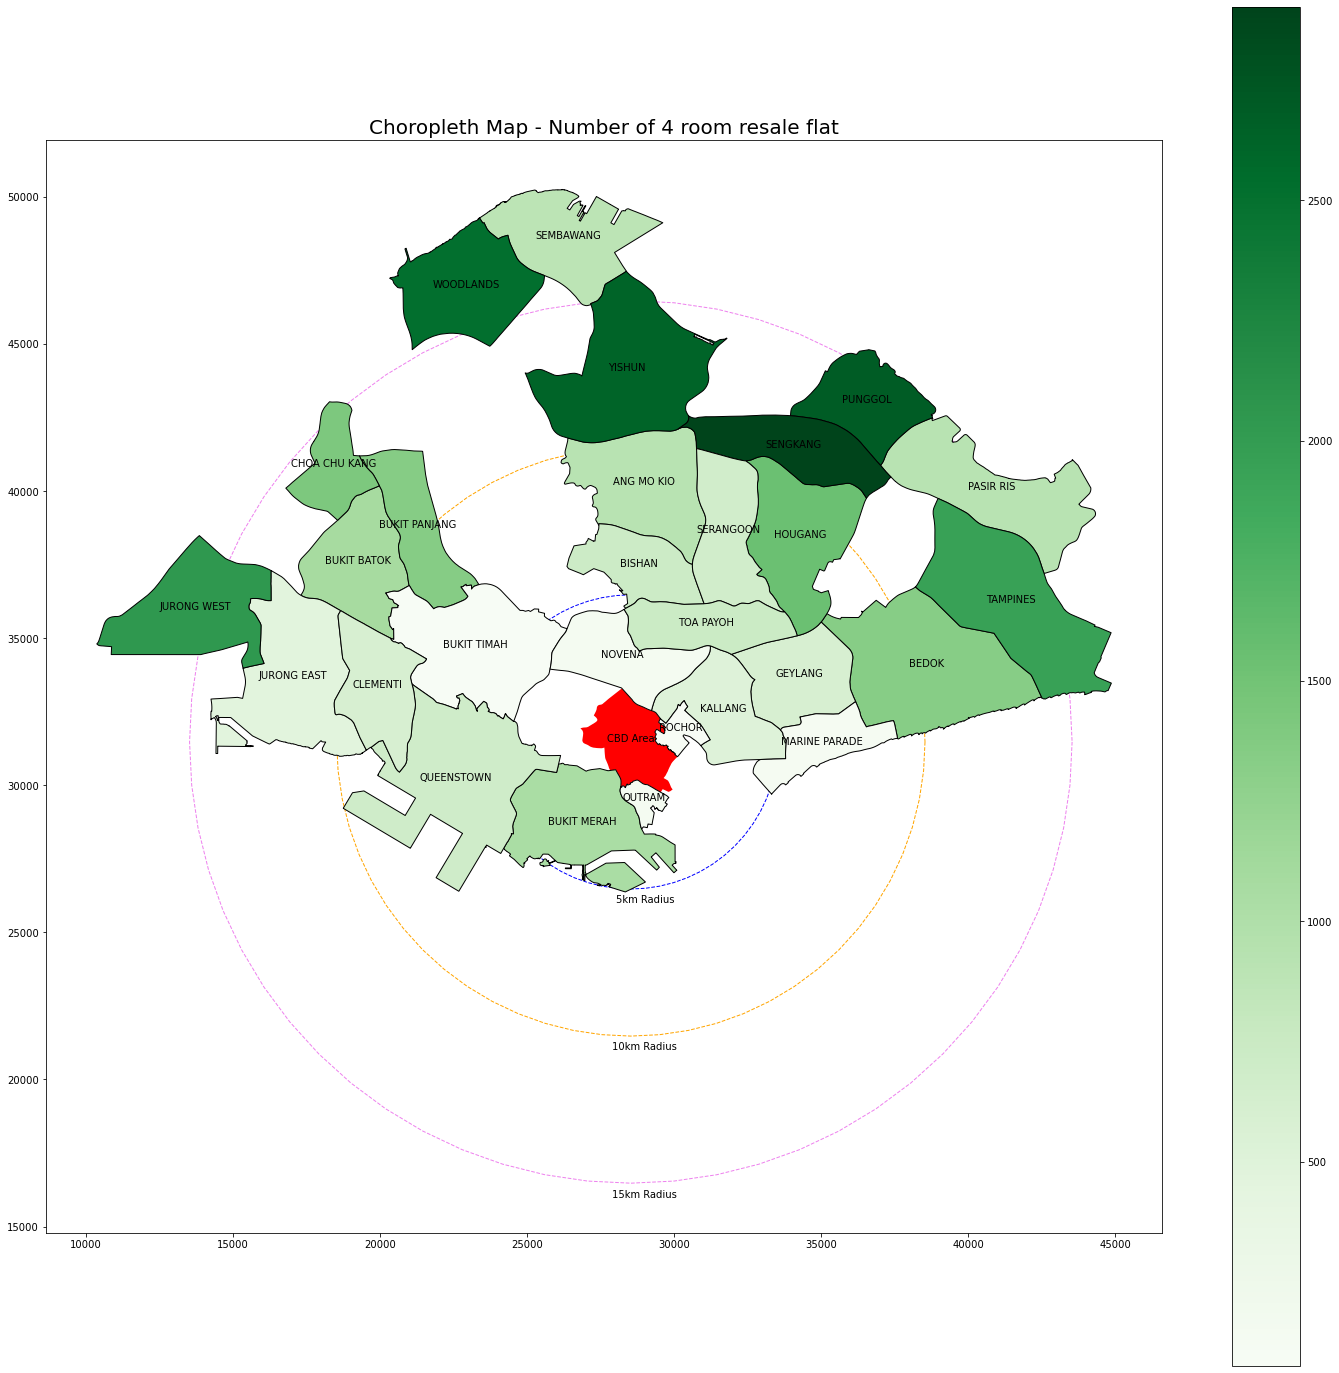

In [107]:
#Number of resale flat

ax = CBD_map.plot(color='red',figsize = (25,25))
radius_5km.plot(ax=ax, color='None', edgecolor ='blue',linestyle='dashed')
radius_10km.plot(ax=ax, color='None', edgecolor ='orange',linestyle='dashed')
radius_15km.plot(ax=ax, color='None', edgecolor ='violet', linestyle='dashed')
housing_map.plot(ax=ax, column = 'district_count',legend=True,edgecolor ='black',
                 cmap='Greens').set_title('Choropleth Map - Number of 4 room resale flat',fontsize=20)

# Annodation for CBD
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

# Annodation for radius
plt.annotate('5km Radius', xy = [29000, 26000], horizontalalignment = 'center')
plt.annotate('10km Radius', xy = [29000, 21000], horizontalalignment = 'center')
plt.annotate('15km Radius', xy = [29000, 16000], horizontalalignment = 'center')

# Annodation for housing district
for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)),
                 horizontalalignment = 'center')

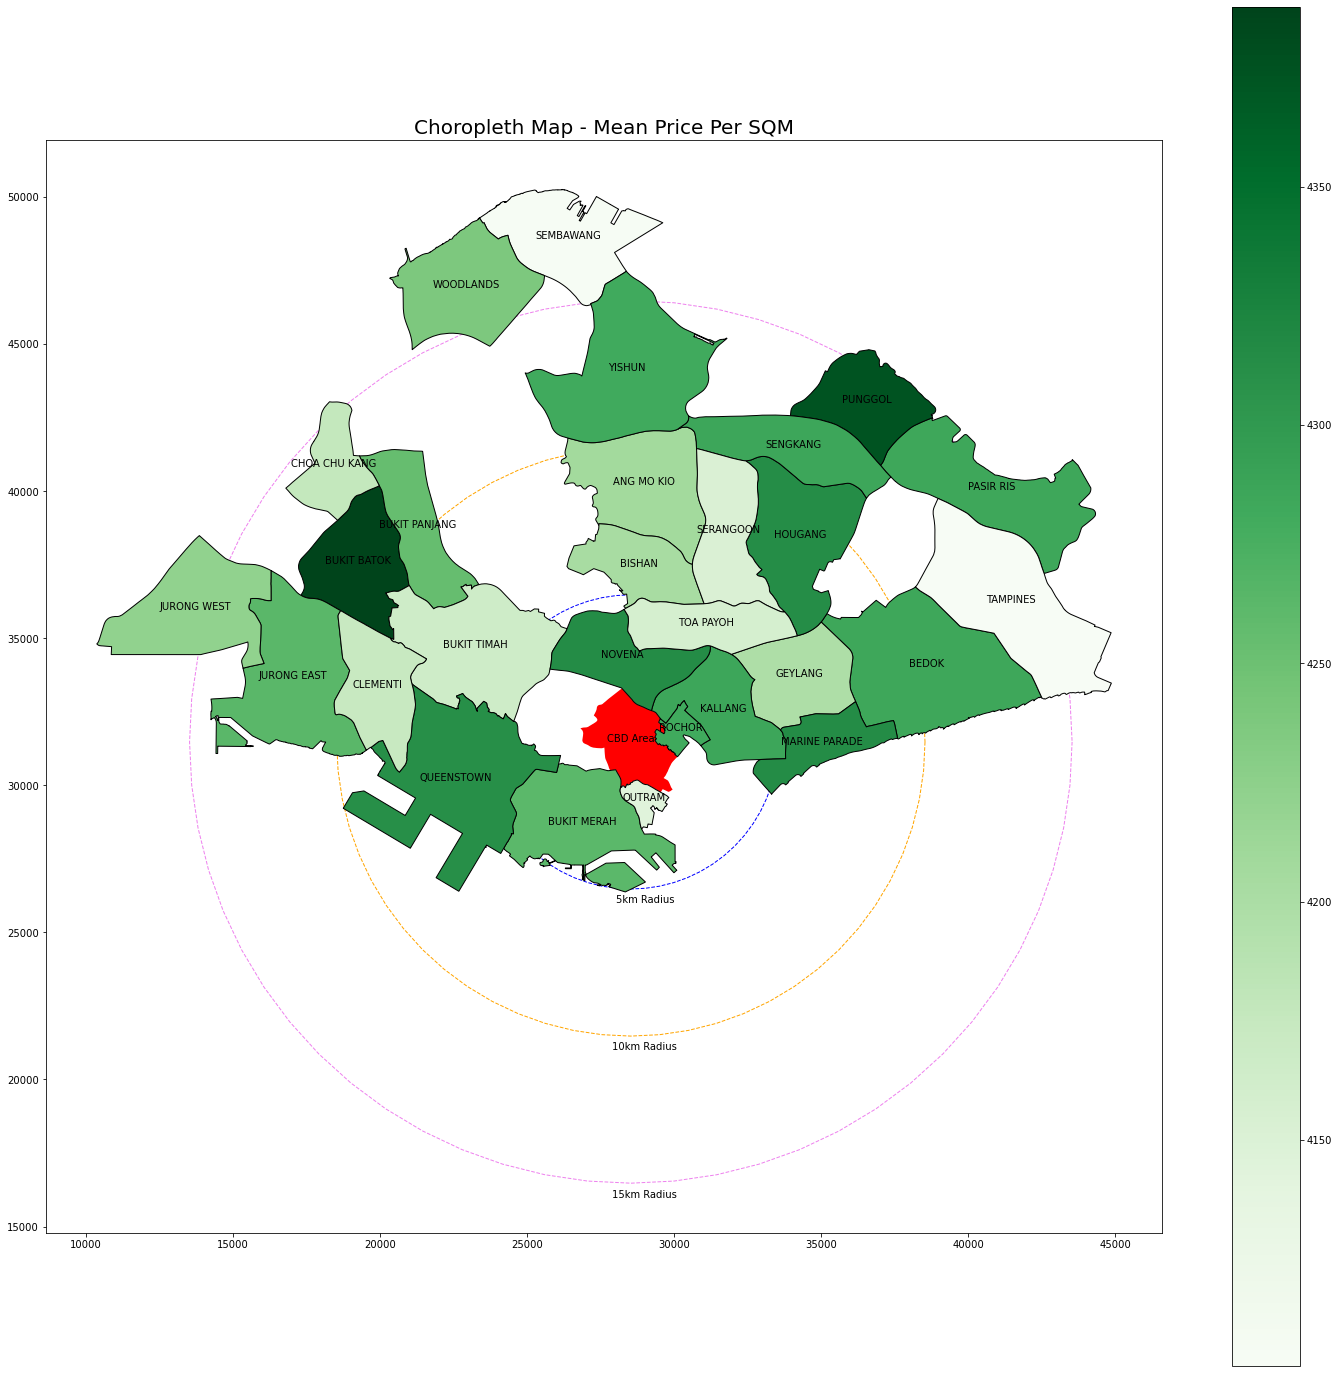

In [102]:
#Mean Price/Metre sq

ax = CBD_map.plot(color='red',figsize = (25,25))
radius_5km.plot(ax=ax, color='None', edgecolor ='blue',linestyle='dashed')
radius_10km.plot(ax=ax, color='None', edgecolor ='orange',linestyle='dashed')
radius_15km.plot(ax=ax, color='None', edgecolor ='violet', linestyle='dashed')
housing_map.plot(ax=ax, column = 'district_mean',legend=True,edgecolor ='black',
                 cmap='Greens').set_title('Choropleth Map - Mean Price Per SQM',fontsize=20)

# Annodation for CBD
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

# Annodation for radius
plt.annotate('5km Radius', xy = [29000, 26000], horizontalalignment = 'center')
plt.annotate('10km Radius', xy = [29000, 21000], horizontalalignment = 'center')
plt.annotate('15km Radius', xy = [29000, 16000], horizontalalignment = 'center')

# Annodation for housing district
for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)),
                 horizontalalignment = 'center')

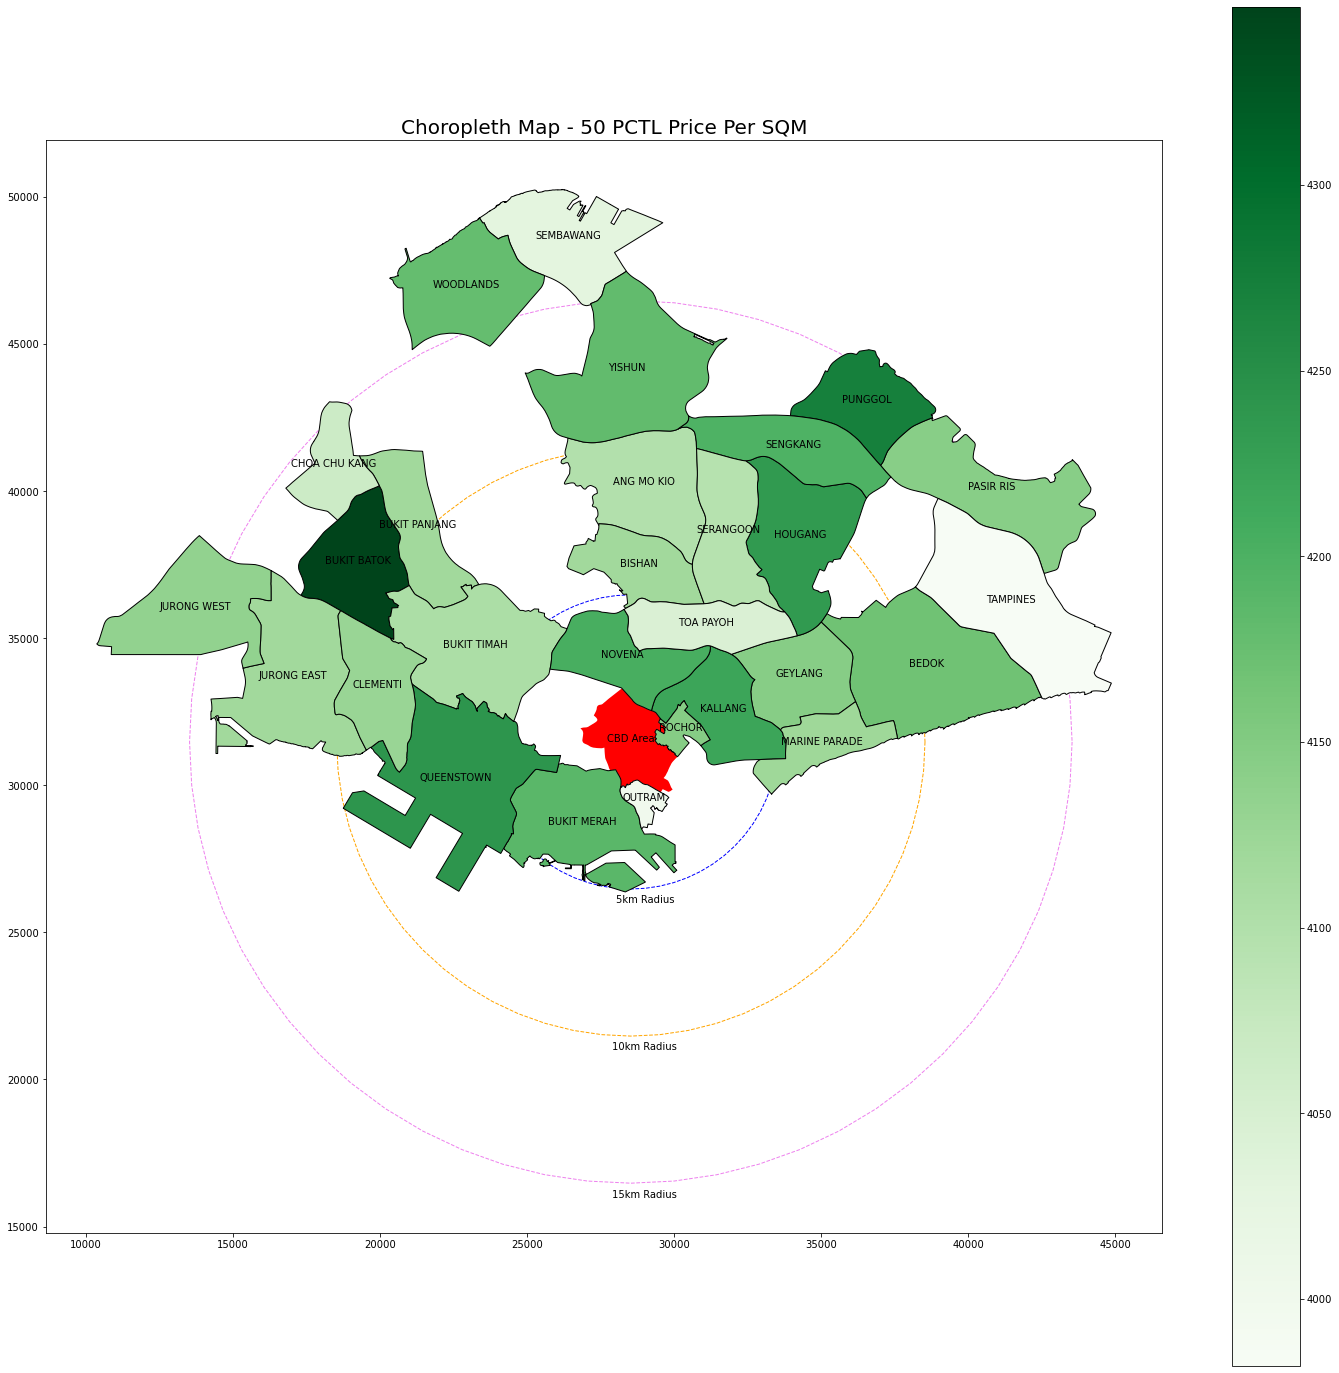

In [103]:
#50 Percentile Price Per SQM

ax = CBD_map.plot(color='red',figsize = (25,25))
radius_5km.plot(ax=ax, color='None', edgecolor ='blue',linestyle='dashed')
radius_10km.plot(ax=ax, color='None', edgecolor ='orange',linestyle='dashed')
radius_15km.plot(ax=ax, color='None', edgecolor ='violet', linestyle='dashed')
housing_map.plot(ax=ax, column = 'district_50',legend=True,edgecolor ='black',
                 cmap='Greens').set_title('Choropleth Map - 50 PCTL Price Per SQM',fontsize=20)

# Annodation for CBD
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

# Annodation for radius
plt.annotate('5km Radius', xy = [29000, 26000], horizontalalignment = 'center')
plt.annotate('10km Radius', xy = [29000, 21000], horizontalalignment = 'center')
plt.annotate('15km Radius', xy = [29000, 16000], horizontalalignment = 'center')

# Annodation for housing district
for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)),
                 horizontalalignment = 'center')

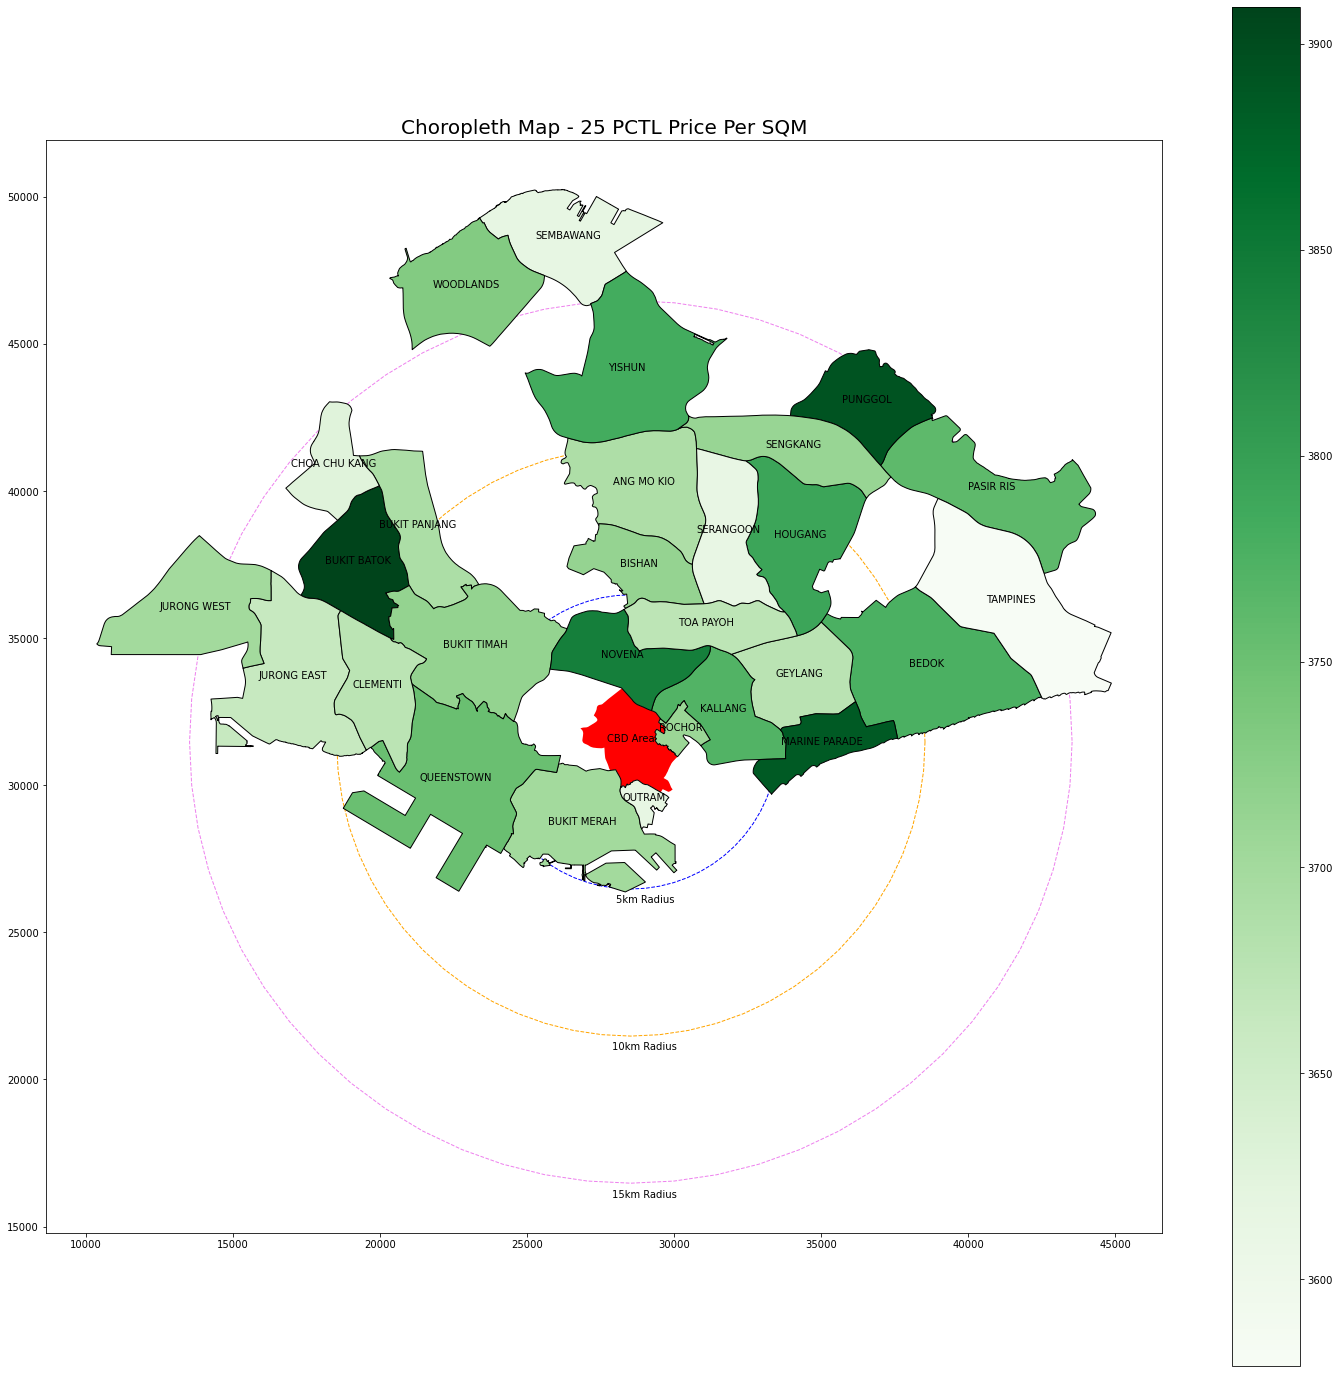

In [104]:
#25 Percentile Price Per SQM

ax = CBD_map.plot(color='red',figsize = (25,25))
radius_5km.plot(ax=ax, color='None', edgecolor ='blue',linestyle='dashed')
radius_10km.plot(ax=ax, color='None', edgecolor ='orange',linestyle='dashed')
radius_15km.plot(ax=ax, color='None', edgecolor ='violet', linestyle='dashed')
housing_map.plot(ax=ax, column = 'district_25',legend=True,edgecolor ='black',
                 cmap='Greens').set_title('Choropleth Map - 25 PCTL Price Per SQM',fontsize=20)

# Annodation for CBD
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

# Annodation for radius
plt.annotate('5km Radius', xy = [29000, 26000], horizontalalignment = 'center')
plt.annotate('10km Radius', xy = [29000, 21000], horizontalalignment = 'center')
plt.annotate('15km Radius', xy = [29000, 16000], horizontalalignment = 'center')

# Annodation for housing district
for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)),
                 horizontalalignment = 'center')

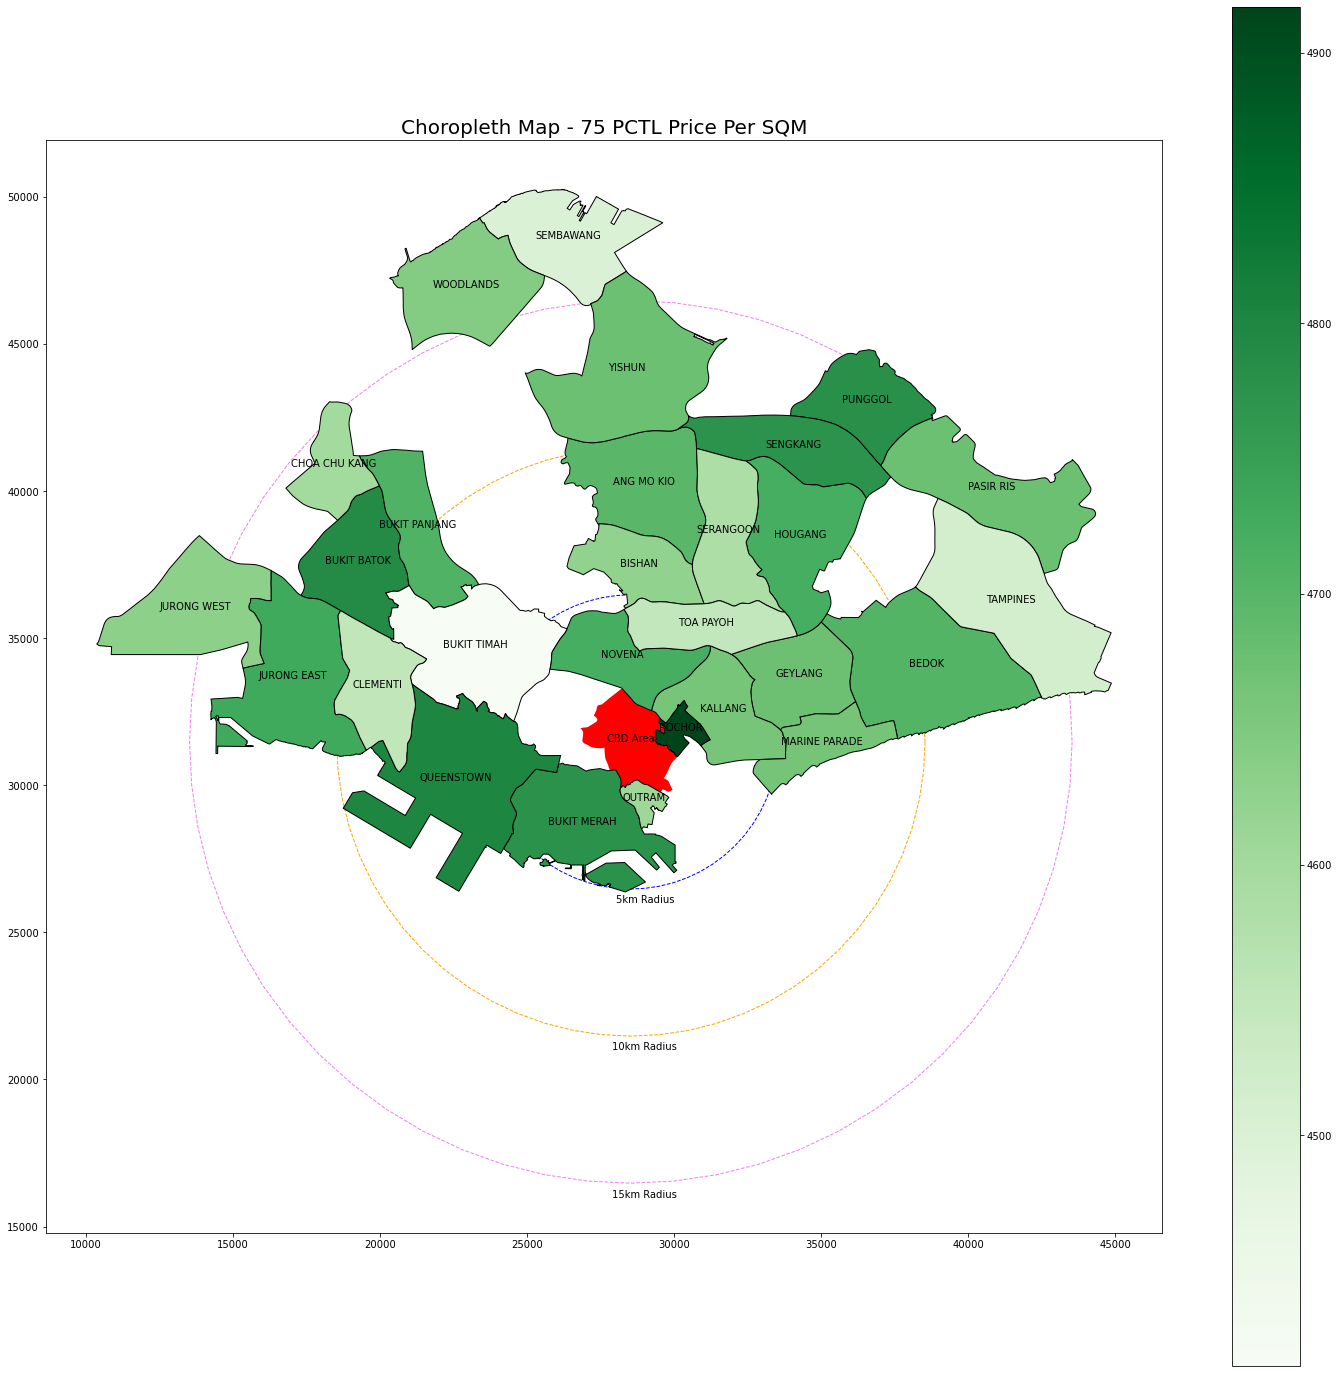

In [105]:
#75 Percentile Price Per SQM

ax = CBD_map.plot(color='red',figsize = (25,25))
radius_5km.plot(ax=ax, color='None', edgecolor ='blue',linestyle='dashed')
radius_10km.plot(ax=ax, color='None', edgecolor ='orange',linestyle='dashed')
radius_15km.plot(ax=ax, color='None', edgecolor ='violet', linestyle='dashed')
housing_map.plot(ax=ax, column = 'district_75',legend=True,edgecolor ='black',
                 cmap='Greens').set_title('Choropleth Map - 75 PCTL Price Per SQM',fontsize=20)

# Annodation for CBD
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

# Annodation for radius
plt.annotate('5km Radius', xy = [29000, 26000], horizontalalignment = 'center')
plt.annotate('10km Radius', xy = [29000, 21000], horizontalalignment = 'center')
plt.annotate('15km Radius', xy = [29000, 16000], horizontalalignment = 'center')

# Annodation for housing district
for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)),
                 horizontalalignment = 'center')

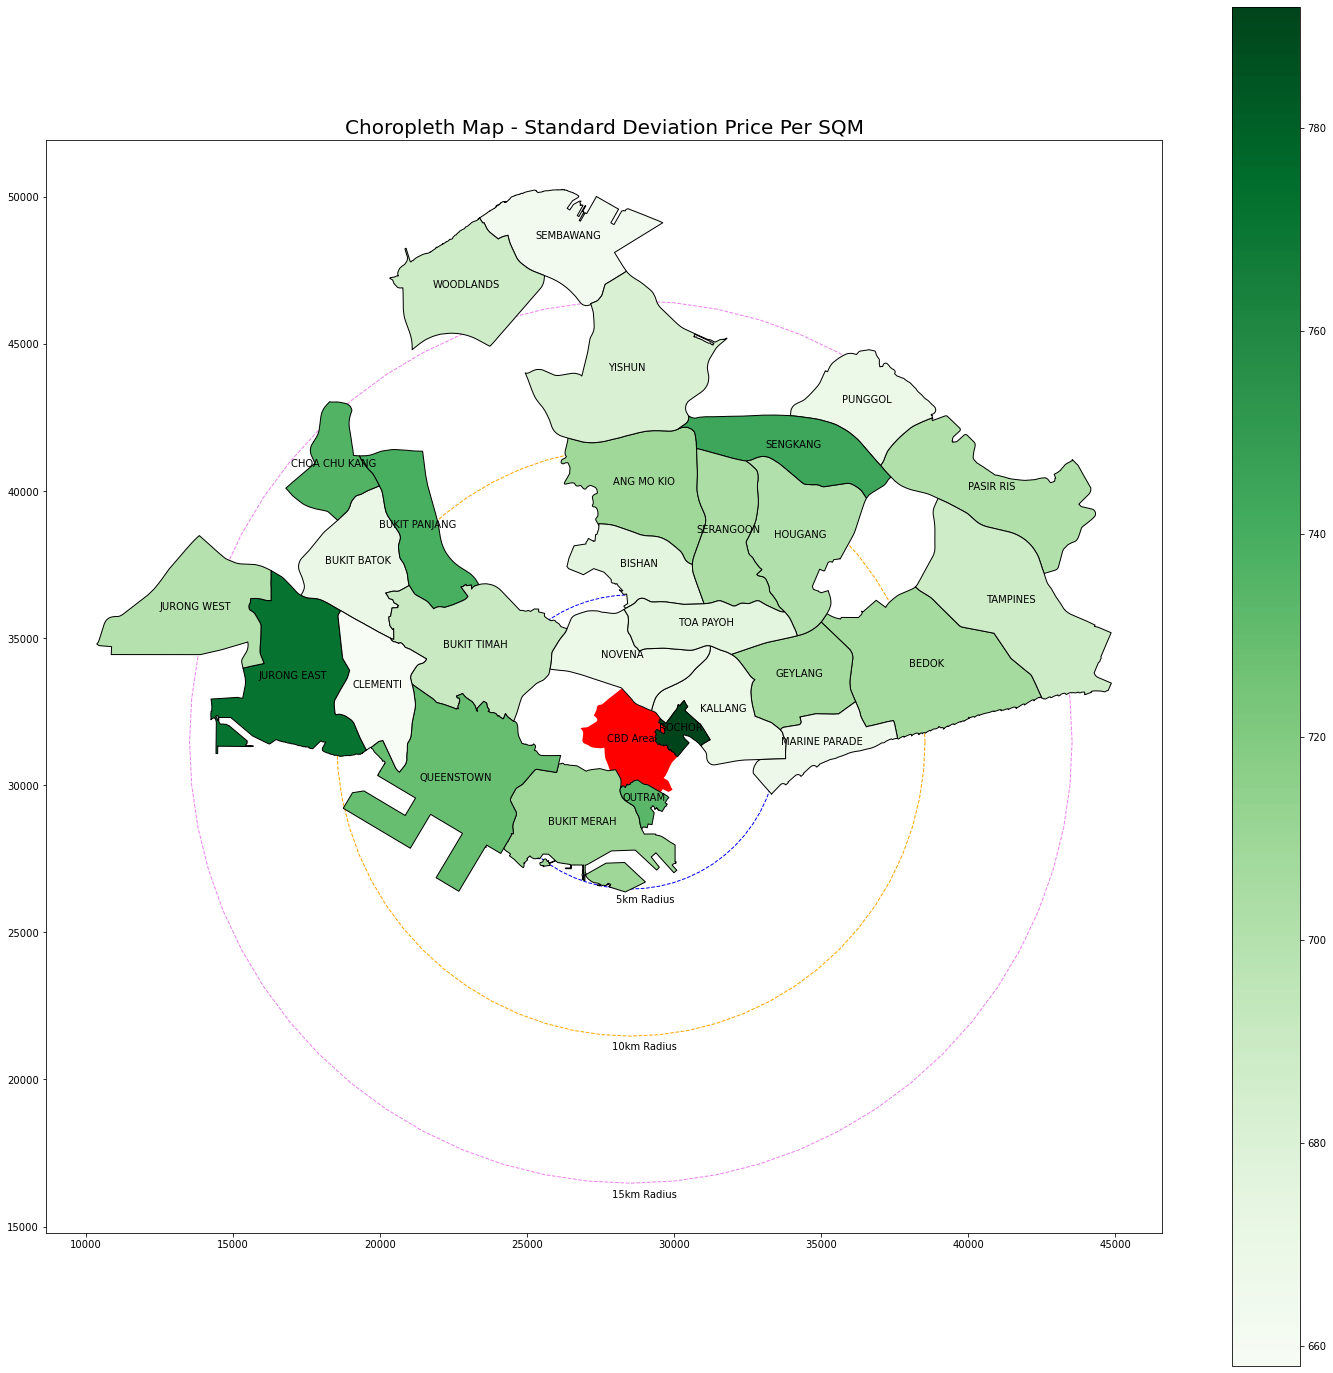

In [108]:
#Standard Deviation Price Per SQM

ax = CBD_map.plot(color='red',figsize = (25,25))
radius_5km.plot(ax=ax, color='None', edgecolor ='blue',linestyle='dashed')
radius_10km.plot(ax=ax, color='None', edgecolor ='orange',linestyle='dashed')
radius_15km.plot(ax=ax, color='None', edgecolor ='violet', linestyle='dashed')
housing_map.plot(ax=ax, column = 'district_std',legend=True,edgecolor ='black',
                 cmap='Greens').set_title('Choropleth Map - Standard Deviation Price Per SQM',fontsize=20)

# Annodation for CBD
plt.annotate('CBD Area', xy = geotofloat(CBD_map), horizontalalignment = 'center')

# Annodation for radius
plt.annotate('5km Radius', xy = [29000, 26000], horizontalalignment = 'center')
plt.annotate('10km Radius', xy = [29000, 21000], horizontalalignment = 'center')
plt.annotate('15km Radius', xy = [29000, 16000], horizontalalignment = 'center')

# Annodation for housing district
for i in range(0, len(housing_map)):
    plt.annotate(housing_map.PLN_AREA_N[i], xy = geotofloat(gpd.GeoSeries(housing_map.geometry[i].centroid)),
                 horizontalalignment = 'center')